# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


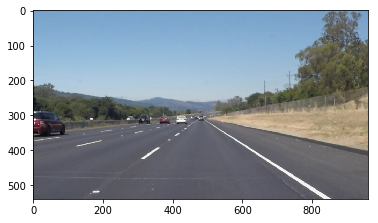

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def convert_hls(image):
    """ Converts RGB to HLS"""
    return cv2.cvtColor(image, cv2.COLOR_RGB2HLS)

def filter_white_yellow(image):
    """ Filters image focus only on white and yellow range"""
    converted = convert_hls(image)
   # white color mask
    lower = np.uint8([  0, 200,   0])
    upper = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(converted, lower, upper)
    # yellow color mask
    lower = np.uint8([ 10,   0, 100])
    upper = np.uint8([ 40, 255, 255])
    yellow_mask = cv2.inRange(converted, lower, upper)
    # combine the mask
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    return cv2.bitwise_and(image, image, mask = mask)

def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

# average and extrapolate lines
# based on slope, try to get the left lane and right lane
# vertical line will be ignore
def average_lines(lines):
    left_lines = []
    left_weights = []
    right_lines = []
    right_weights = []
    if lines is None:
        return None
    for line in lines:
        for x1,y1,x2,y2 in line:
            if x1==x2:
                continue # ignore vertical line
            slope = (y2-y1)/(x2-x1)
            intercept = y1 - x1 * slope
            length = np.sqrt((y2-y1)**2 + (x2-x1)**2)
            if slope < 0:
                left_lines.append((slope, intercept))
                left_weights.append((length))
            else:
                right_lines.append((slope, intercept))
                right_weights.append((length))
    left_lane = []
    if len(left_weights) > 0:
        left_lane = np.dot(left_weights, left_lines) / np.sum(left_weights)
    right_lane = []
    if len(right_weights) > 0:
        right_lane = np.dot(right_weights, right_lines) / np.sum(right_weights)
    return left_lane, right_lane

def convert_line_pixels(y1, y2, line):
    """ Convert slope and intercept to points pixel"""
    if line is None:
        return None
    # Check to make sure the input is fine before processing
    if len(line) == 0:
        return None
    slope, intercept = line
    # Make sure the slope is not 0
    if slope == 0:
        return None
    x1 = int((y1 - intercept)/slope)
    x2 = int((y2 - intercept)/slope)
    y1 = int(y1)
    y2 = int(y2)
    
    return ((x1, y1), (x2, y2))

def lane_lines(img, lines):
    left_lane, right_lane = average_lines(lines)
    # convert to line pixels
    y1 = img.shape[0]
    y2 = y1 * 0.6
    
    
    
    left_line = convert_line_pixels(y1, y2, left_lane)
    right_line = convert_line_pixels(y1, y2, right_lane)
    return left_line, right_line

def draw_lines(img, lines, color=[255, 0, 0], thickness=14):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    if lines is None:
        return None
    
    lanes = lane_lines(img, lines)
    line_image = np.zeros_like(img)
    
    for lane in lanes:
        cv2.line(line_image, *lane, color, thickness)
    
    return weighted_img(line_image, img)

def draw_lines_img(line_img, lines, color=[255, 0, 0], thickness=2):
     
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(line_img, (x1, y1), (x2, y2), color, thickness)

def hough_lines_image(img, lines):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    
    draw_lines_img(line_img, lines)
    return line_img

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    return lines

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=1.0, β=0.95, λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)


# Define the show_images function - show images for testing
def show_images(images, cmap=None):
    cols = 2
    rows = (len(images)+1)//2
    
    plt.figure(figsize=(13,14))
    for i, img in enumerate(images):
        if(len(img.shape) == 2):
            cmap = 'gray'
        
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img, cmap=cmap)
    plt.show()
    
    

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
os.listdir("test_images/")

['result',
 'solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg',
 'zChallenge1.jpg',
 'zChallengeCurved.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

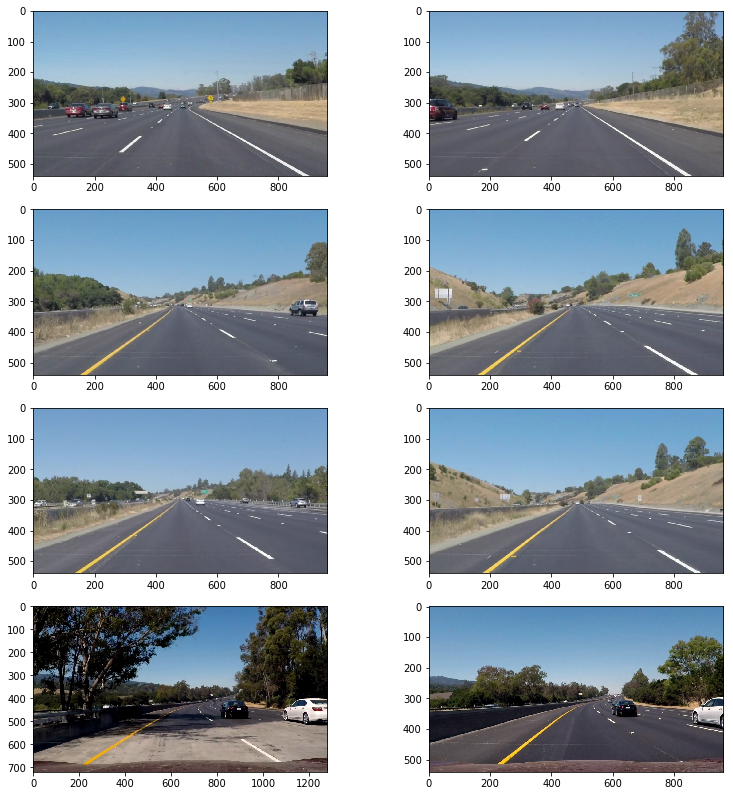

In [5]:
import glob
# Show the test images
test_images = [plt.imread(path) for path in glob.glob('test_images/*.jpg')]
show_images(test_images)

### Convert RGB image to HLS
Convert image from RGB color space to HLS color space for easier on filter yellow and white colors.

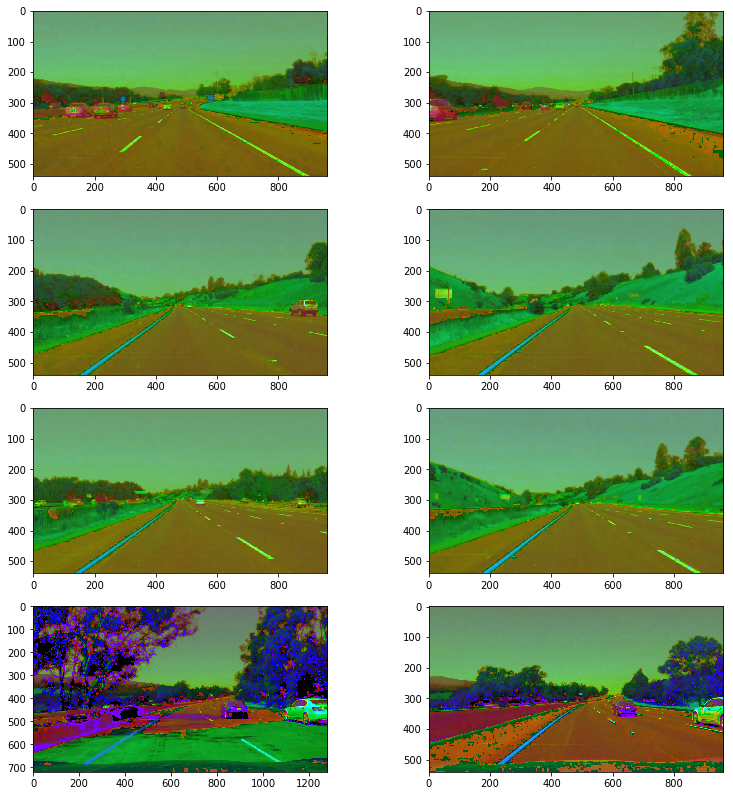

In [6]:
# debug flag
debug = True
# Test the convert_hls function
test_hls_images = list(map(convert_hls, test_images))
if debug:
    show_images(test_hls_images)

### Filter image on yellow and white colors
Filter the noise by focus on yellow and white line lane color only. I use the cv2.inRange() function with the color mask for yellow and white by copy from [Naoki's article](https://medium.com/towards-data-science/finding-lane-lines-on-the-road-30cf016a1165)

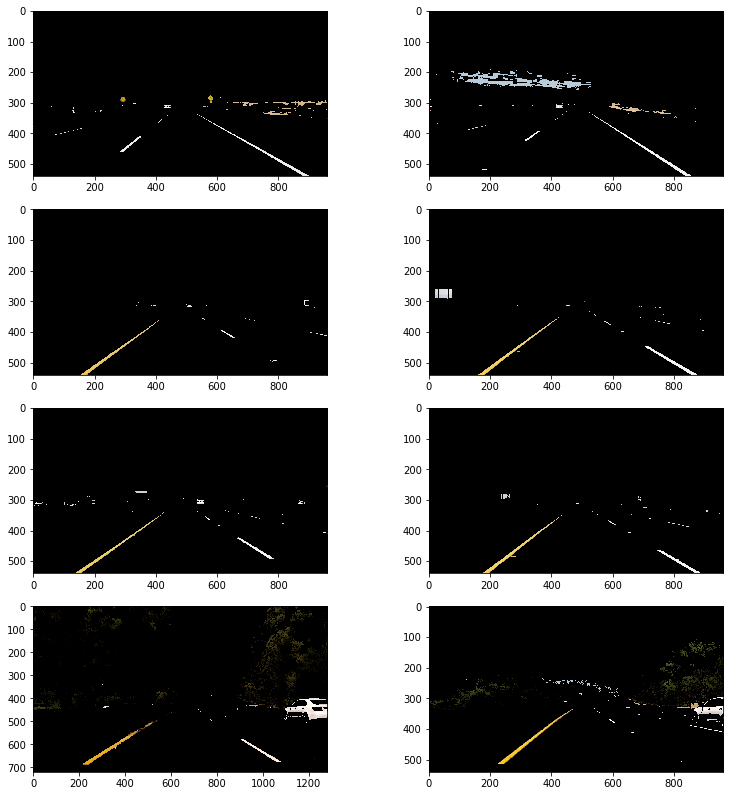

In [7]:
white_yellow_images = list(map(filter_white_yellow, test_images))

if debug:
    show_images(white_yellow_images)

### Gray scaling
In order to detect edges in the images based on the magnitude of piexl intensity changes using Canny edge detection, they will be converted to gray scaled. This step converts the yellow and white images into gray scale for edge detection.

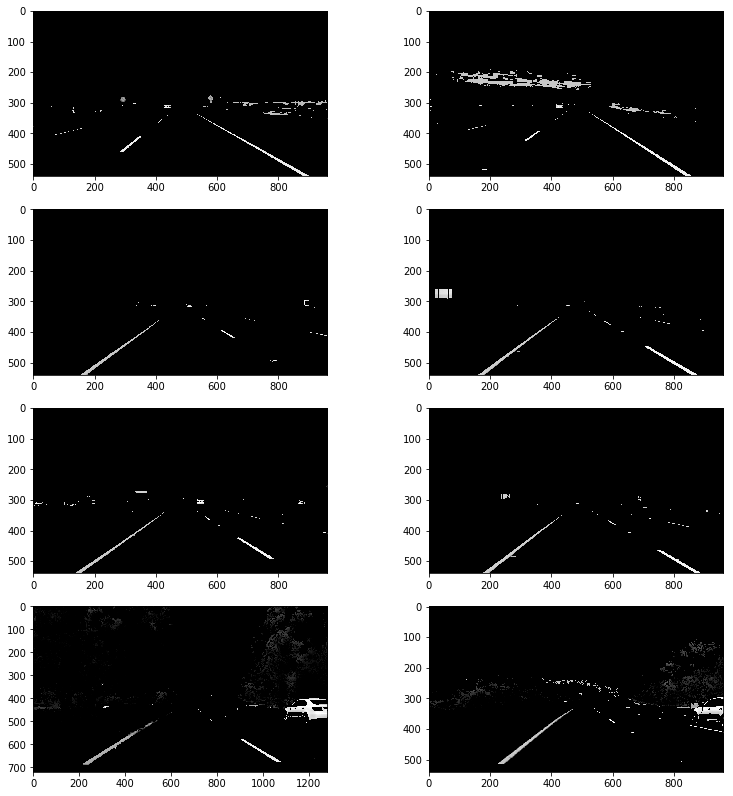

In [8]:
# Show the gray test images
gray_images = list(map(grayscale, white_yellow_images))
if debug:
    show_images(gray_images)

### Gaussian Blur
In order to make the edges smoother, the images will be applied gaussian blur. I have tried the kernel size from 1, 3, 5, 7, 9, 11, 13 and 15 values (odd values), the bigger kernel size can make the images become smoother. First of all, I choose the kernel_size is 13 for cv2.GaussianBlur function. After received a useful feedback from my reviewer, I changed it to 5 and it's working better.

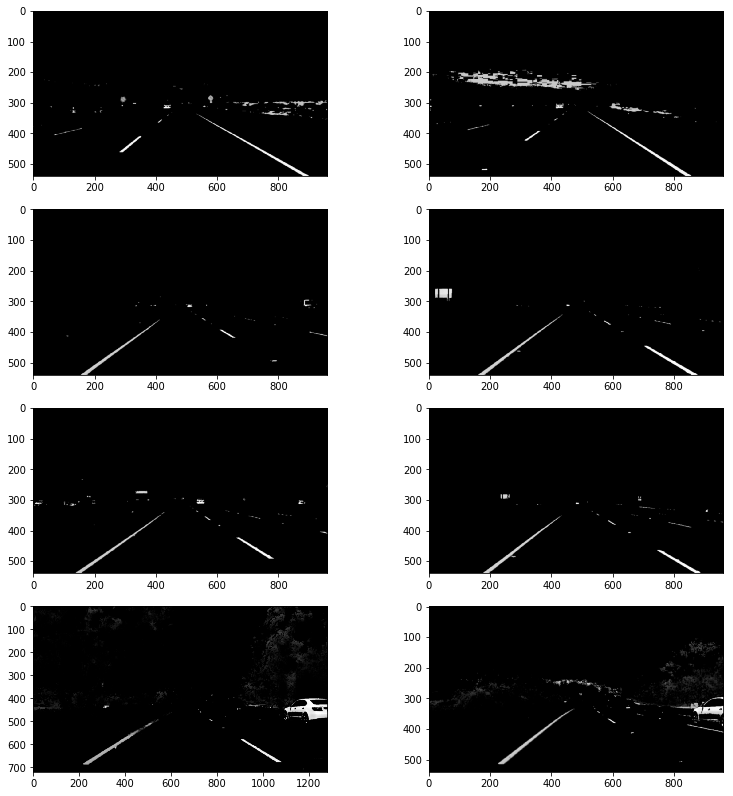

In [9]:
# Gaussian Blur
kernel_size = 5
blur_images = list(map(lambda gray: gaussian_blur(gray, kernel_size), gray_images))
if debug:
    show_images(blur_images)

### Detect edges with canny
This step uses cv2.canny() function to detect edges. I have tried to play with the high and low thresold in order to detect edges clearly. Canny recommended a upper:lower ratio between 2:1 and 3:1. I choose the upper:lower is 150:50.

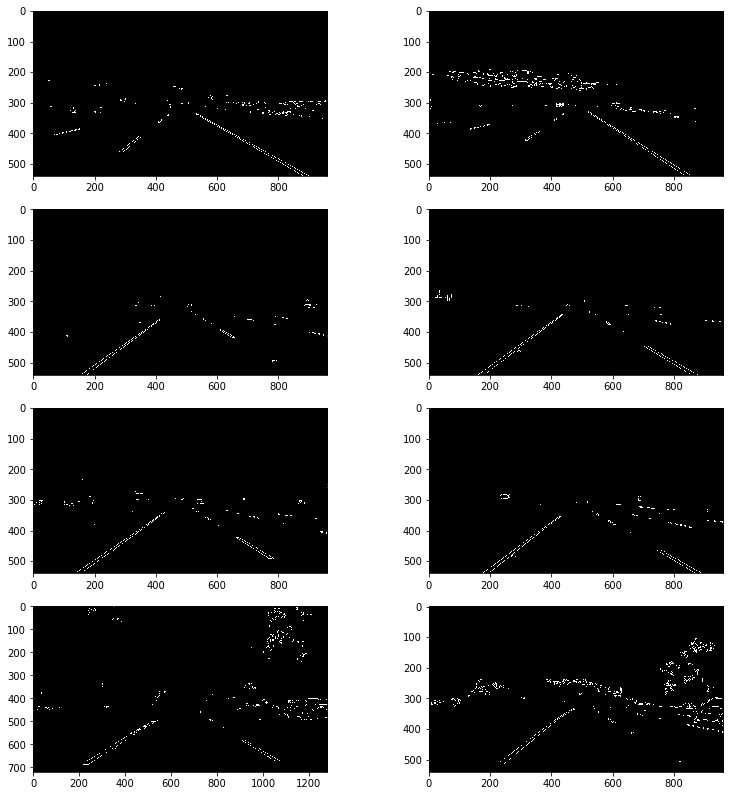

In [10]:
# Detect edges with canny
low_thresold = 50
high_thresold = 150
edges_images = list(map(lambda blur:canny(blur, low_thresold, high_thresold), blur_images))
if debug:
    show_images(edges_images)

### Select region of interest
I need to focus on a speacial region that have lane lines and skip the other such as the sky, the other cars. First of all, I have tried with a hard code region and it works fine with test images. However, I had stucks with images from video because they have a bigger size than test images (1280 x 720 compares with 960 x 540), so I chose vertices based on image size for more flexible.

In [11]:
# define the region of interest vertices based on image size
def calculate_roi(img):
    rows, cols = img.shape[:2]
    p1 = [cols*0.1, rows*0.95]
    p2 = [cols*0.4, rows*0.6]
    p3 = [cols*0.6, rows*0.6] 
    p4 = [cols*0.9, rows*0.95]
    vertices = np.array([[p1, p2, p3, p4]], dtype=np.int32)
    return vertices


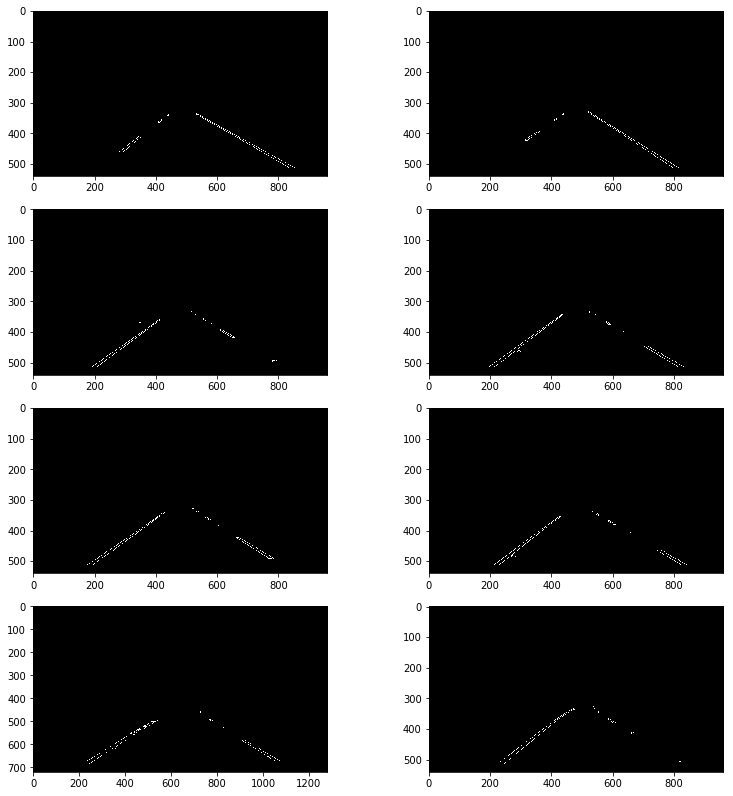

In [12]:
# filter region of interest
# define the vertices following image size for more flexible.
roi_images = list(map(lambda edges: region_of_interest(edges, calculate_roi(edges)), edges_images))
if debug:
    show_images(roi_images)


### Hough transform lines detection
This step uses the cv2.HoughLinesP function to detect the lines in the edge images. It's very difficult to me for choosing the optimization parameter for this function. I have played with many options in order to get the good parameters for detecting the lines clearly.

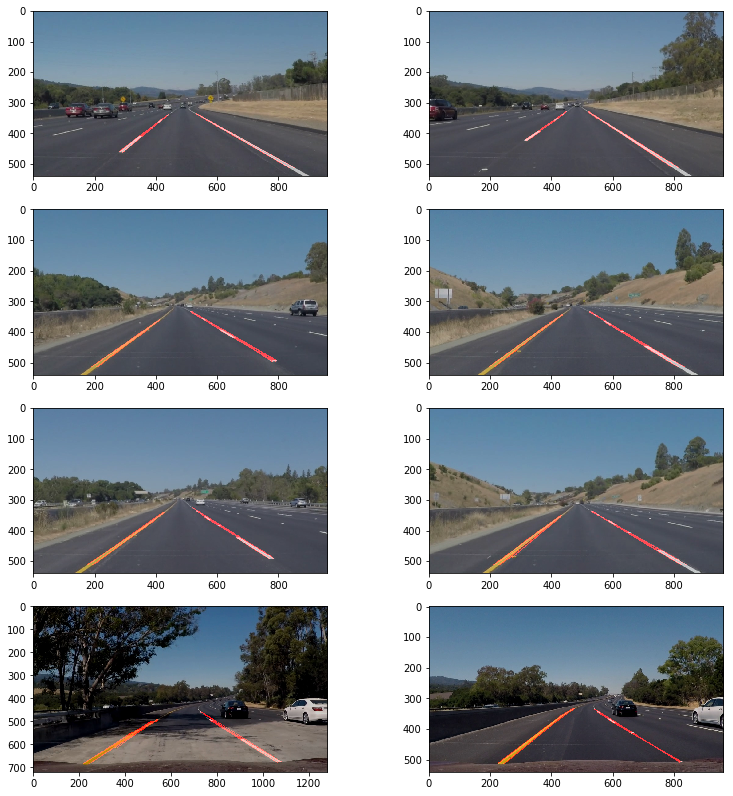

In [13]:
# Hough lines 
rho = 2
theta = np.pi/180
threshold = 20
min_line_len = 25
max_line_gap = 290
# Hough transform lines
list_of_lines = list(map(lambda roi_image:hough_lines(roi_image, rho, theta, threshold, min_line_len, max_line_gap), roi_images))

list_lines = []
# hough line images
for lines, img in zip(list_of_lines, roi_images):
    list_lines.append(hough_lines_image(img, lines))
line_images = []
# weight lines to original images
for lines, img in zip(list_lines, test_images):
    line_images.append(weighted_img(lines, img, 0.8, 1, 0))
if debug:
    show_images(line_images)

### Average and Extrapolate Lines
After the hough transform lines detection, the lines are detected on road images now. However, these lines are not connected and expanded fully on image. This step tried to average and extrapolate these lines together based on slope and intercept. The left lane should have a negative slope, and the right lane should have a positive slope. I have modified the draw_lines() function to draw lane line clearly.


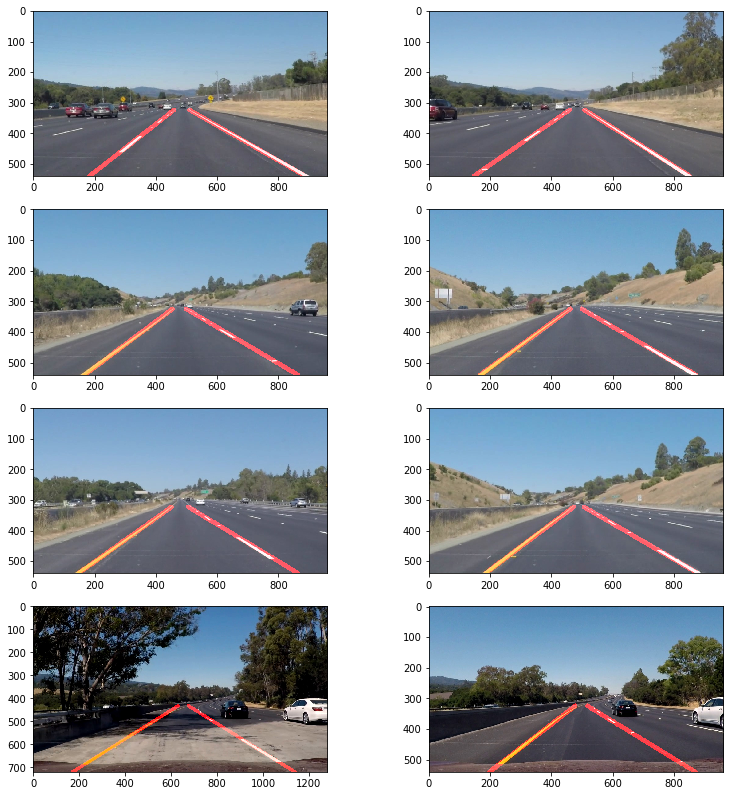

In [14]:
lane_images = []

for img, lines in zip(test_images, list_of_lines):
    lane_images.append(draw_lines(img, lines))
if debug:
    show_images(lane_images)

### Putting everything together for processing one image
Every steps run fine and we have the optimization parameters. Now this time to put everything together to implement a function to process one image through all pipelines.

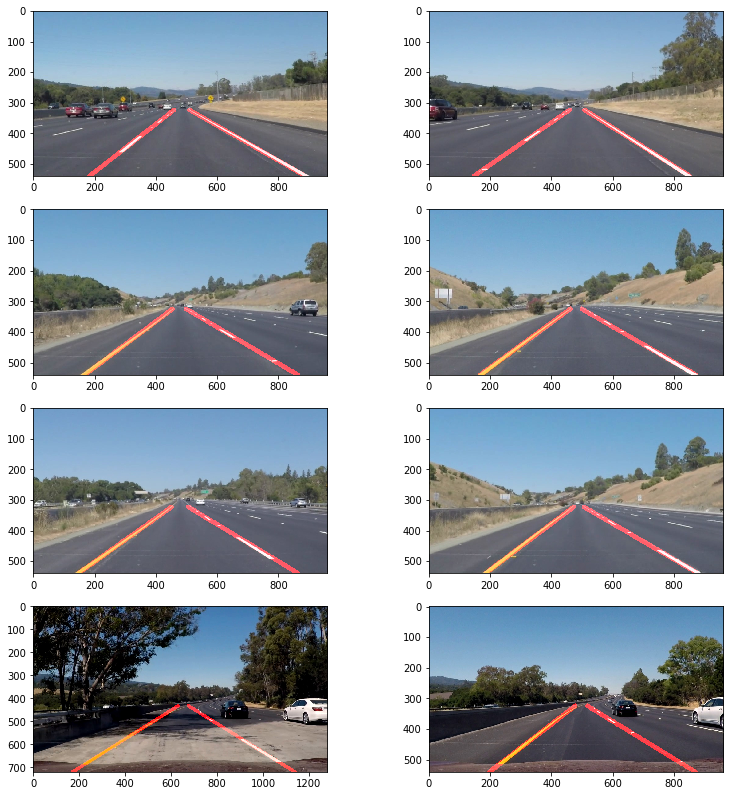

In [15]:
# The lane is drawn clearly now. It's time to put everything together

def draw_laneline(img):
    yellow_white = filter_white_yellow(img)
    gray = grayscale(yellow_white)
    blur_gray = gaussian_blur(gray, kernel_size)
    edges = canny(blur_gray, low_thresold, high_thresold)
    marked_edges = region_of_interest(edges, calculate_roi(edges))
    lines = hough_lines(marked_edges, rho, theta, threshold, min_line_len, max_line_gap)    
    combo = draw_lines(img, lines)
    return combo
# Test with test images
test_images_output = list(map(draw_laneline, test_images))
if debug:
    show_images(test_images_output)


## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [16]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

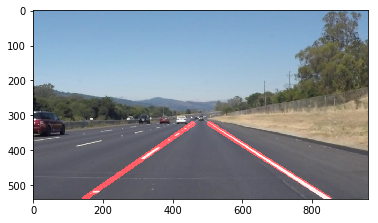

In [17]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    result = draw_laneline(image)
    if result is not None:
        return result
    else:
        # save to error_images for debug
        img_out_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB )
        cv2.imwrite('error_images/error.jpg', img_out_rgb)
        return image
plt.imshow(process_image(image))

Let's try the one with the solid white lane on the right first ...

In [18]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,15)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|███████████████████████████████████████████████████████████████████████████████▋| 221/222 [00:03<00:00, 65.74it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

Wall time: 3.7 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [19]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [20]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|███████████████████████████████████████████████████████████████████████████████▉| 681/682 [00:10<00:00, 61.57it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

Wall time: 10.8 s


In [21]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [22]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(4,10)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 251/251 [00:07<00:00, 33.70it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

Wall time: 8.15 s


In [23]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))